# Mall Customers Clustering (K-Means, PCA, UMAP, HDBSCAN) 

This example uses an enhanced version of the mall customers dataset from Week 5 

Preprocess data, a bit of feature engineering, PCA, clustering and then plotting

## Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import datetime

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import utils as ut

#want to filter the seaborn warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

## Constants and Functions
Migrate these to a separate package when done so they can be used with scripts

In [3]:
RSEED=7

#lets compare each feature to all other features
def show_pairplot(df, hue):
    '''
    Shows a pairplot comparing all the features in a dataframe
    '''
    #this works on a small dataset, will be prohibitivly slow on a larger one
    To_Plot = [ col for col in df.columns]
    print("Relative Plot Of Some Selected Features: A Data Subset")
    plt.figure();
    # sns.pairplot(data=df[To_Plot], hue=hue, palette=ut.colors1)
    sns.pairplot(data=df[To_Plot], hue=hue,palette = "Paired");
    # plt.show();

## Download the dataset 

In [5]:
# Download once (won't re-download if file exists)
import os, subprocess, shutil, urllib.request
DATA_URL = "https://raw.githubusercontent.com/CNUClasses/DATA301_CODE/master/week_6/Mall_CustomersNew.csv"
DATA_PATH = "Mall_CustomersNew.csv"

if os.path.exists(DATA_PATH):
    print(f"{DATA_PATH} already exists — skipping download.")
else:
    urllib.request.urlretrieve(DATA_URL, DATA_PATH)

('Mall_CustomersNew.csv', <http.client.HTTPMessage at 0x7fd1634d4650>)

## Load Data

In [ ]:
#load
df= pd.read_csv(DATA_PATH)
df

CustomerID  Gender  Annual Income (k$)    Birthday  spending_alcohol  \
0             1    Male                15.0  2004-04-22         11.623344   
1             2    Male                15.0  2002-09-05         26.986170   
2             3  Female                16.0  2003-10-28          1.087533   
3             4  Female                16.0  2000-09-02         26.988725   
4             5  Female                17.0  1992-11-10         12.693410   
..          ...     ...                 ...         ...               ...   
200         200    Male               137.0  1993-07-15         42.905180   
201         200    Male               137.0  1993-07-15         42.905180   
202         200    Male               137.0  1993-07-15         42.905180   
203         200    Male               137.0  1993-07-15         42.905180   
204         200    Male               137.0  1993-07-15         42.905180   

     spending_food  spending_sale  Active  
0         8.185354      19.191302    True  
1        27.769286      26.244544    True  
2         1.697070       3.215396    True  
3        17.576664      32.434611    True  
4        12.820811      14.485779    True  
..             ...            ...     ...  
200      29.614241      10.480579    True  
201      29.614241      10.480579    True  
202      29.614241      10.480579    True  
203      29.614241      10.480579    True  
204      29.614241      10.480579    True  

[205 rows x 8 columns]

### sns.pairplot to see if anything looks funny

Active has no variance (run df.nunique())

CustomerID is weirdly correlated with Annual Income.  It appears that they collected all customer data, sorted by income, and then assigned a customer ID to the sorted data

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

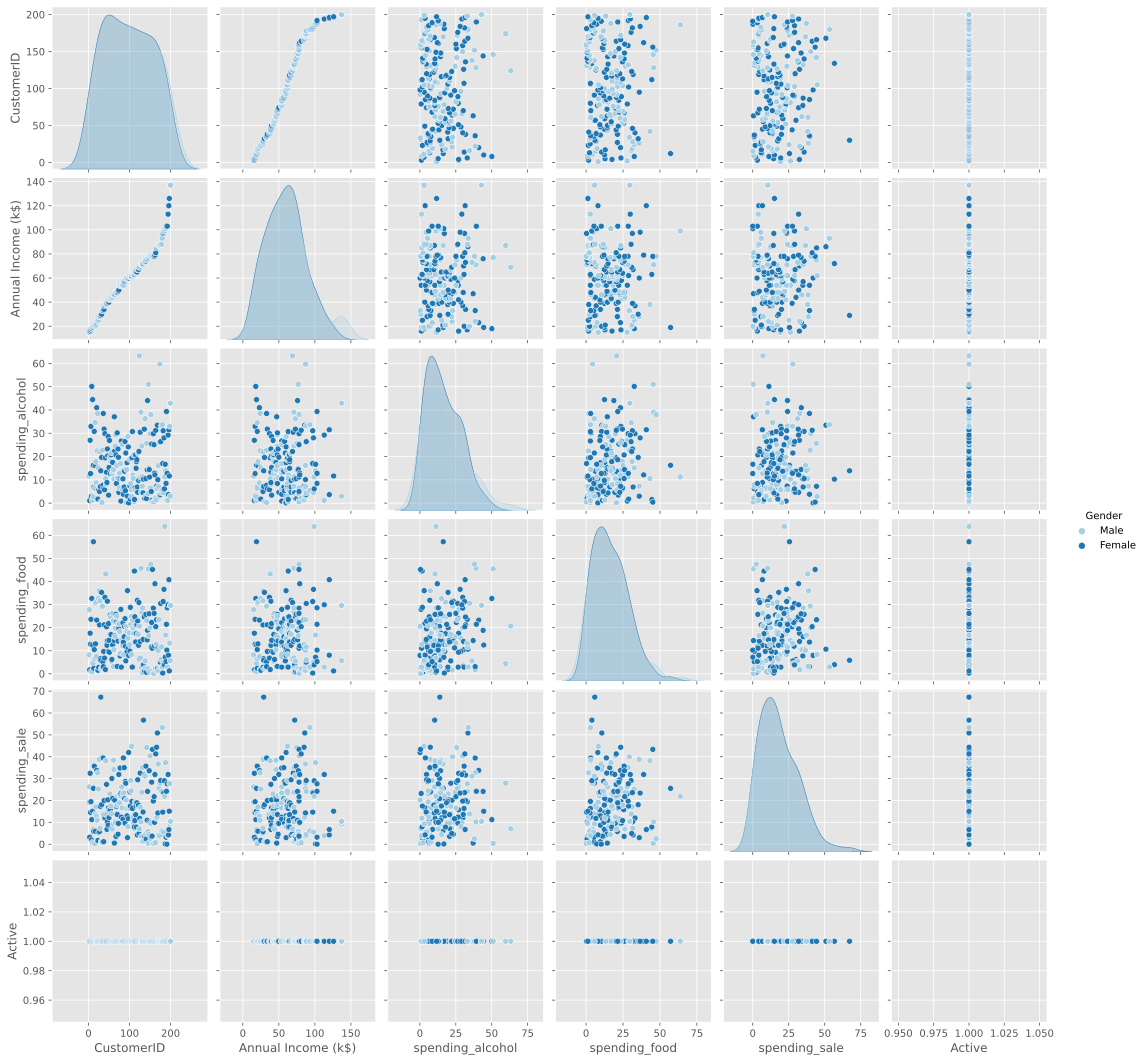

In [128]:
show_pairplot(df,hue='Gender');

## Clean Data

In [129]:
from utils.transforms import *

### Drop duplicates 

In [130]:
df=ut.remove_duplicates(df)

Removing 5 duplicate rows


### Handle nulls
Just drop if there are not too many and you can't figure out how to estimate<br>
(You could estimate by taking the value before and after since the data was sorted by income before CustomerIDs were assigned )


In [132]:
#how many rows have nulls?
df.isna().sum(axis=1).sum()

#see em
df[df.isnull().any(axis=1)]

1

CustomerID Gender  Annual Income (k$)    Birthday  spending_alcohol  \
197         198   Male                 NaN  1991-06-17          33.02982   

     spending_food  spending_sale  Active  
197       13.27501       27.69517    True

In [133]:
#just 1 row with null in Annual Income

#get its index
index=df[df.isnull().any(axis=1)].index[0]
print(index)

197


In [134]:
#whats the income for the rows before and after
vals=df.loc[index-1: index+1, 'Annual Income (k$)']
print(vals)

# index
# #want to estimate, just take the id before and the id after and average the incomes
# # get before and after index
df.loc[index, 'Annual Income (k$)']=vals.mean()

196    126.0
197      NaN
198    137.0
Name: Annual Income (k$), dtype: float64


In [ ]:
#or just drop it
# df.dropna(axis=0, inplace=True)

### Convert birthday to age

In [135]:
#convert birthday to age in years
import datetime
def getyear(v):
    return datetime.datetime.now().year - pd.to_datetime(v).year
df['Birthday']=df.Birthday.map(getyear) 
df.rename(columns={"Birthday": "Age"}, inplace=True)

### Correlations?
Careful you want to drop the columns with the least info

In [137]:
#any correlations?
ut.get_correlated_columns(df)

[('Annual Income (k$)', 'CustomerID')]

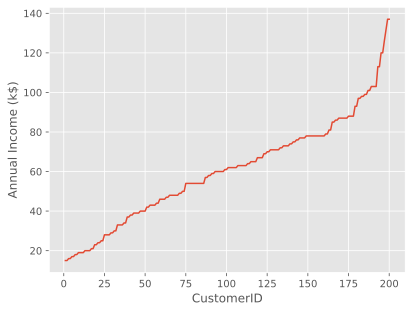

In [142]:
sns.lineplot(data=df, y='Annual Income (k$)',x='CustomerID');

#### Annual Income is highly (and weirdly) correlated with CustomerID, drop one.  But be sure to keep the one that has the most information!

Looks like they sorted the dataset by incone then assigned consecutive IDs

CustomerID is likely unique for every customer, and contains no info, drop it

In [143]:
print(f'There are {df.CustomerID.nunique()} unique customer IDs and {len(df)} rows in df')

There are 200 unique customer IDs and 200 rows in df


In [144]:
df.drop(columns=['CustomerID'], inplace=True)

### Drop no variance columns

In [145]:
df=ut.drop_no_variance_columns(df)

dropping columns ['Active'] since each only has 1 value


In [146]:
df.head()

Gender  Annual Income (k$)  Age  spending_alcohol  spending_food  \
0    Male                15.0   21         11.623344       8.185354   
1    Male                15.0   23         26.986170      27.769286   
2  Female                16.0   22          1.087533       1.697070   
3  Female                16.0   25         26.988725      17.576664   
4  Female                17.0   33         12.693410      12.820811   

   spending_sale  
0      19.191302  
1      26.244544  
2       3.215396  
3      32.434611  
4      14.485779

### Feature engineering- Should you combine all spending columns into 1?  This assummes one value can accurately capture spending patterns and reduces the number of features.  On the other hand, you know people who drink a lot or who like to shop on sale, or are foodies.  To start leave as 3 seperate columns.

In [ ]:
#function to combine columns if you choose to use
def combine_columns(df, newcolname, cols ):
    '''
    df: dataframe
    newcolname: the name of the column to create that has the sum of all columns in cols
    cols: list of columns to add
    return: modded dataframe
    '''
    df[newcolname] = df[cols].sum(axis=1)
    df.drop(cols, axis=1, inplace=True)
    return df

# cols=[col for col in df.columns if "spending" in col]
# data=combine_columns(df,"spending_total",cols)

### Categoricals

In [147]:
#find categoricals, use df.dtypes, look for the object columns
df.dtypes

Gender                 object
Annual Income (k$)    float64
Age                     int64
spending_alcohol      float64
spending_food         float64
spending_sale         float64
dtype: object

#### Gender 

In [148]:
#looks like Gender
print (df.Gender.unique())

['Male' 'Female']


In [149]:
#gender is nominal, but it is binary ie male or female
#try a binary variable instead of dummies to reduce dimensionality
feats=['Gender']

#either of these
#convert Gender
d= {v:i for i,v in enumerate(df.Gender.unique().tolist())}
df.Gender=df.Gender.map(d)
# df=ut.cat_ordinal(df, features=feats, order={'Gender':{'Male':0, 'Female':1}})

### Save a copy of dataframe to append clusters to

In [150]:
dforig=df.copy()

### Standardize

In [151]:
df=ut.scale(df)
df

Gender  Annual Income (k$)       Age  spending_alcohol  spending_food  \
0         0           -1.735315 -1.424569         -0.367079      -0.662625   
1         0           -1.735315 -1.281035          0.866707       0.938238   
2         1           -1.697250 -1.352802         -1.213209      -1.193002   
3         1           -1.697250 -1.137502          0.866913       0.105055   
4         1           -1.659184 -0.563369         -0.281142      -0.283706   
..      ...                 ...       ...               ...            ...   
195       1            2.261572 -0.276302          1.229167       2.001653   
196       1            2.489966  0.441365         -0.365183      -1.229698   
197       0            2.699327 -0.491602          1.352072      -0.246578   
198       0            2.908687 -0.491602         -1.059920      -0.863528   
199       0            2.908687 -0.635135          2.145161       1.089051   

     spending_sale  
0         0.114435  
1         0.660934  
2        -1.123411  
3         1.140553  
4        -0.250159  
..             ...  
195      -0.851703  
196      -0.202189  
197       0.773332  
198      -0.653814  
199      -0.560490  

[200 rows x 6 columns]

# Dimensionality reduction
Lets try a couple of different ways 

## PCA 

A linear dimensionality reduction algorithm, works well for data distributions that are linear

In [152]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.95)
features_pca=pd.DataFrame(pca.fit_transform(df))
print(f'Orig #features={df.shape[1]}, number features containing 95% of variance={features_pca.shape[1]}')

features_pca
pca.explained_variance_ratio_

Orig #features=6, number features containing 95% of variance=5


0         1         2         3         4
0   -0.216993 -1.610585  1.243870  0.732965 -0.877490
1   -1.818564 -1.755401  0.131129  0.301118 -0.250509
2    1.076871 -1.600515  1.106020  1.456665 -1.362144
3   -1.602213 -1.666821  0.883306 -0.268443 -0.376578
4    0.141052 -1.636941  0.482068  0.454189 -0.461370
..        ...       ...       ...       ...       ...
195 -1.407214  1.995336 -2.263158  0.511429 -0.055875
196  1.034448  2.553564  0.350399 -0.381071 -0.322715
197 -1.249064  2.727008  0.007984 -0.869959 -0.570445
198  0.968727  2.992989  0.387014  0.901624 -0.514274
199 -1.740965  2.740905 -1.866404 -0.289218 -0.973869

[200 rows x 5 columns]

array([0.31361281, 0.191005  , 0.1642427 , 0.14376152, 0.14096045])

## UMAP

A non-linear dimensionality reduction algorithm, works well for data distributions that are NOT linear. For instance moon shaped. 

In [153]:
# UMAP dimensionality reduction
from umap import UMAP

# Configure UMAP hyperparameters
umap = UMAP(n_neighbors=5, #The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
            min_dist=0.3, # default 0.1, The effective minimum distance between embedded points.
            n_components=5, #The dimension of the space to embed into.  We could make this smaller and plot it
            metric='euclidean',
           random_state=RSEED)

features_umap=pd.DataFrame(umap.fit_transform(df))

/home/keith/anaconda3/envs/p311/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [154]:
features_umap

0         1         2         3         4
0     2.196753  3.984021  4.431987  6.623491  6.224502
1     5.996702  5.807399  3.549853  6.439924  5.183470
2     1.268253  3.191216  4.946653  6.184536  5.446209
3     5.684135  5.564144  3.967340  6.271800  6.237916
4     1.974869  3.557208  4.620167  6.450588  6.009603
..         ...       ...       ...       ...       ...
195  12.093092  7.576309  3.303799  6.882721  3.958235
196  -1.367261  7.060678  5.399153  6.636765  7.200195
197  11.441089  7.764389  2.691002  7.069794  4.199318
198  -1.196030  7.215233  4.771897  6.172933  6.707807
199  11.875391  7.653931  3.036271  7.117011  4.018080

[200 rows x 5 columns]

In [ ]:
# ??UMAP

In [ ]:
features_umap

In [155]:
features_umap.describe()

0           1           2           3           4
count  200.000000  200.000000  200.000000  200.000000  200.000000
mean     3.795810    5.931797    4.685431    6.488515    5.644351
std      4.068154    1.471265    1.581753    0.842810    0.918783
min     -4.203005    3.103275    1.890886    1.836101    3.738026
25%      1.457317    4.869938    3.391168    6.158572    4.958883
50%      2.846910    5.862091    4.435273    6.493715    5.752686
75%      5.694695    7.082306    5.950800    6.996459    6.246486
max     12.342229    8.702535    7.990511    8.007833    7.613426

## Lets plot these reduced dimensionality feature sets and see if we can visually 'see' any clusters

Tell UMAP to generate 2 components
and use the first 2 components of PCA

In [ ]:
# ??UMAP

/home/keith/anaconda3/envs/p311/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


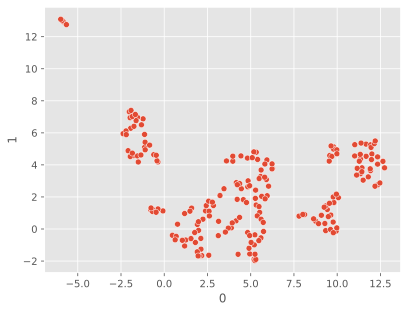

In [156]:
# Want to plot your data and see if there are any clusters?
umap2 = UMAP(n_neighbors=5, #The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
            min_dist=0.3, # default 0.1, The effective minimum distance between embedded points.
            n_components=2, #The dimension of the space to embed into.  We could make this smaller and plot it
            metric='euclidean',
           random_state=RSEED)

features_umap2=pd.DataFrame(umap2.fit_transform(df))
sns.scatterplot(data=features_umap2,x=0,y=1);

<Axes: xlabel='0', ylabel='1'>

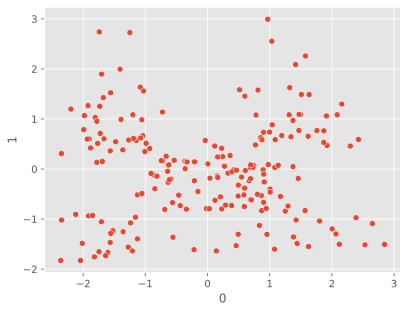

In [157]:
#can do the same for PCA but according to the explained_varience_ratio
#but the first 2 components only capture 50% of the data varience
#and it looks pretty ugly
sns.scatterplot(data=features_pca.iloc[:,[0,1]],x=0,y=1)

# KMEANS

In [159]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

def runkmeansandsilhouette(features, cluster_sizes=[3,4,5,6,7,8,9,10,11,12,13,14,15]):
    '''
    runs kmeans on the features and returns the best cluster labels
    cluster_sizes : list of cluster sizes to try
    features: which features to run kmeans on'''
    bestcluster=None
    for cluster_size in cluster_sizes:   
        kmeans = KMeans(n_clusters=cluster_size, init='k-means++', random_state=RSEED)
        kmeans=kmeans.fit(features) 
        sc=silhouette_score(features, list(kmeans.labels_))
        if bestcluster is None or sc > bestcluster[1]:
            bestcluster=(cluster_size,sc,kmeans.labels_)
        print(f"for {cluster_size} clusters, silhouette_score={silhouette_score(features, list(kmeans.labels_))}") 

    print(f'Best cluster size={bestcluster[0]}')
    return bestcluster[2]

In [160]:
cluster_labels_pca=runkmeansandsilhouette(features_pca)
cluster_labels_umap=runkmeansandsilhouette(features_umap)

for 3 clusters, silhouette_score=0.21254446795625515
for 4 clusters, silhouette_score=0.24014238850929573
for 5 clusters, silhouette_score=0.23835453634491863
for 6 clusters, silhouette_score=0.2458263779408508
for 7 clusters, silhouette_score=0.24672414554798422
for 8 clusters, silhouette_score=0.23518276484608222
for 9 clusters, silhouette_score=0.23875089858111623
for 10 clusters, silhouette_score=0.2424963517654653
for 11 clusters, silhouette_score=0.240575619892308
for 12 clusters, silhouette_score=0.23559160998509066
for 13 clusters, silhouette_score=0.22745038883140004
for 14 clusters, silhouette_score=0.2118436278493622
for 15 clusters, silhouette_score=0.21958345520004194
Best cluster size=7
for 3 clusters, silhouette_score=0.4888370633125305
for 4 clusters, silhouette_score=0.43804267048835754
for 5 clusters, silhouette_score=0.4899581968784332
for 6 clusters, silhouette_score=0.5208413600921631
for 7 clusters, silhouette_score=0.5442245602607727
for 8 clusters, silhouette_sc

In [161]:
#maybe 6 is too many clusters, lets see if we can glean any insights using fewer clusters (try 4)
cluster_labels_pca=runkmeansandsilhouette(features_pca, cluster_sizes=[6])
cluster_labels_umap=runkmeansandsilhouette(features_umap, cluster_sizes=[6])

for 6 clusters, silhouette_score=0.2458263779408508
Best cluster size=6
for 6 clusters, silhouette_score=0.5208413600921631
Best cluster size=6


##  Plot both kmeans clusters derived from umap and from pca

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

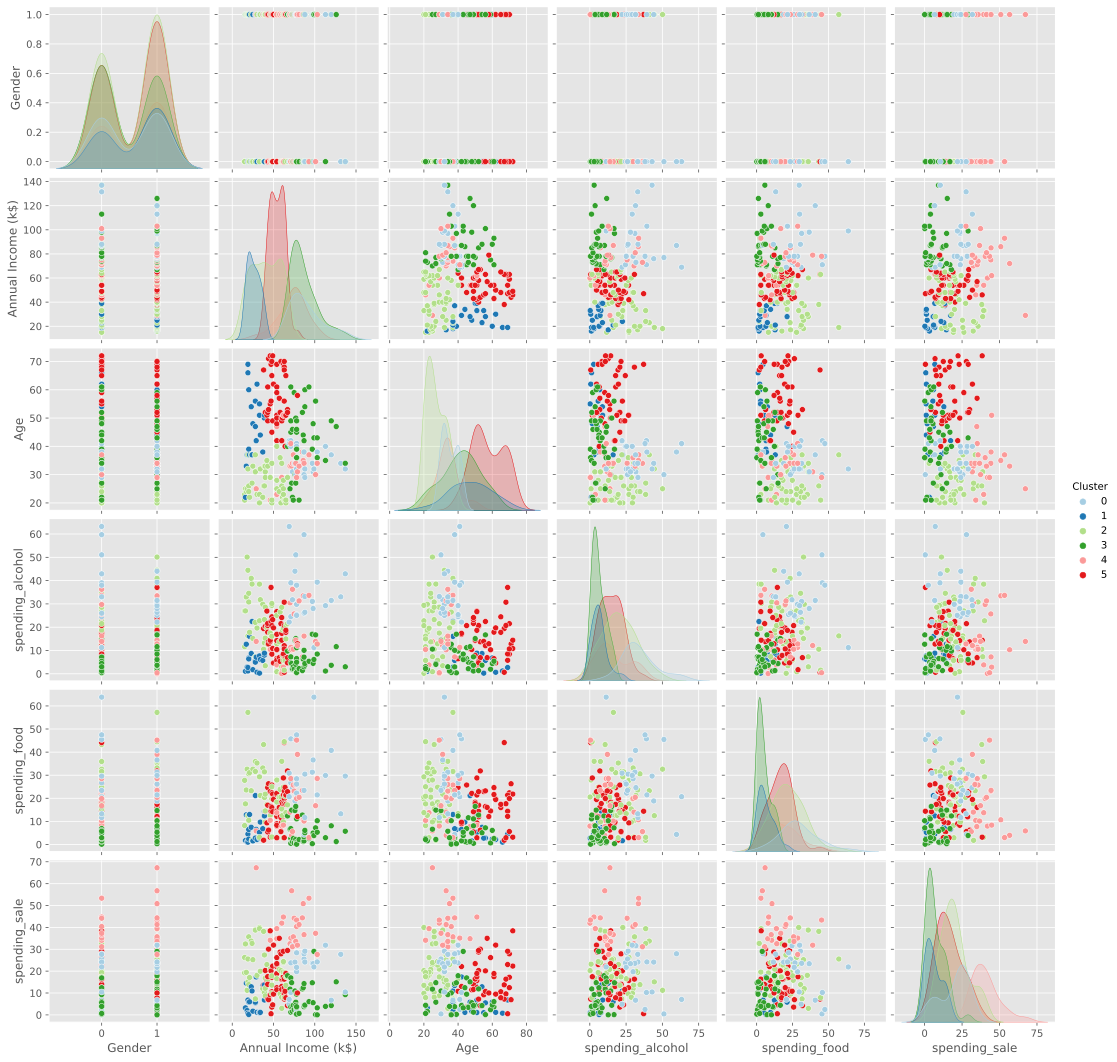

In [162]:
#first PCA
#lets plot the clusters
#only show non outliers
dforig['Cluster']=cluster_labels_pca
show_pairplot(dforig,hue='Cluster');

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

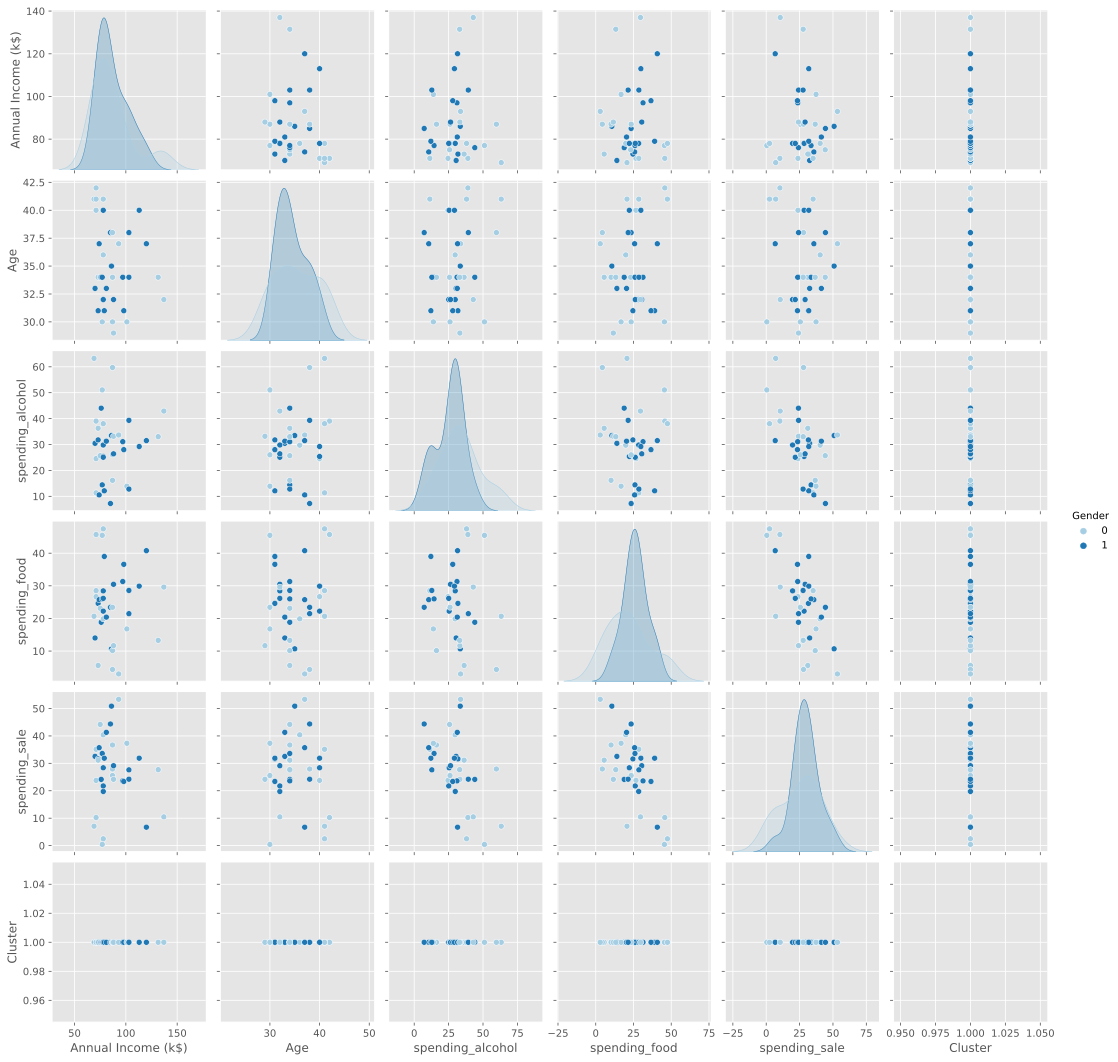

In [165]:
dfslce=dforig[dforig.Cluster==1]
show_pairplot(dfslce,hue='Gender');

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

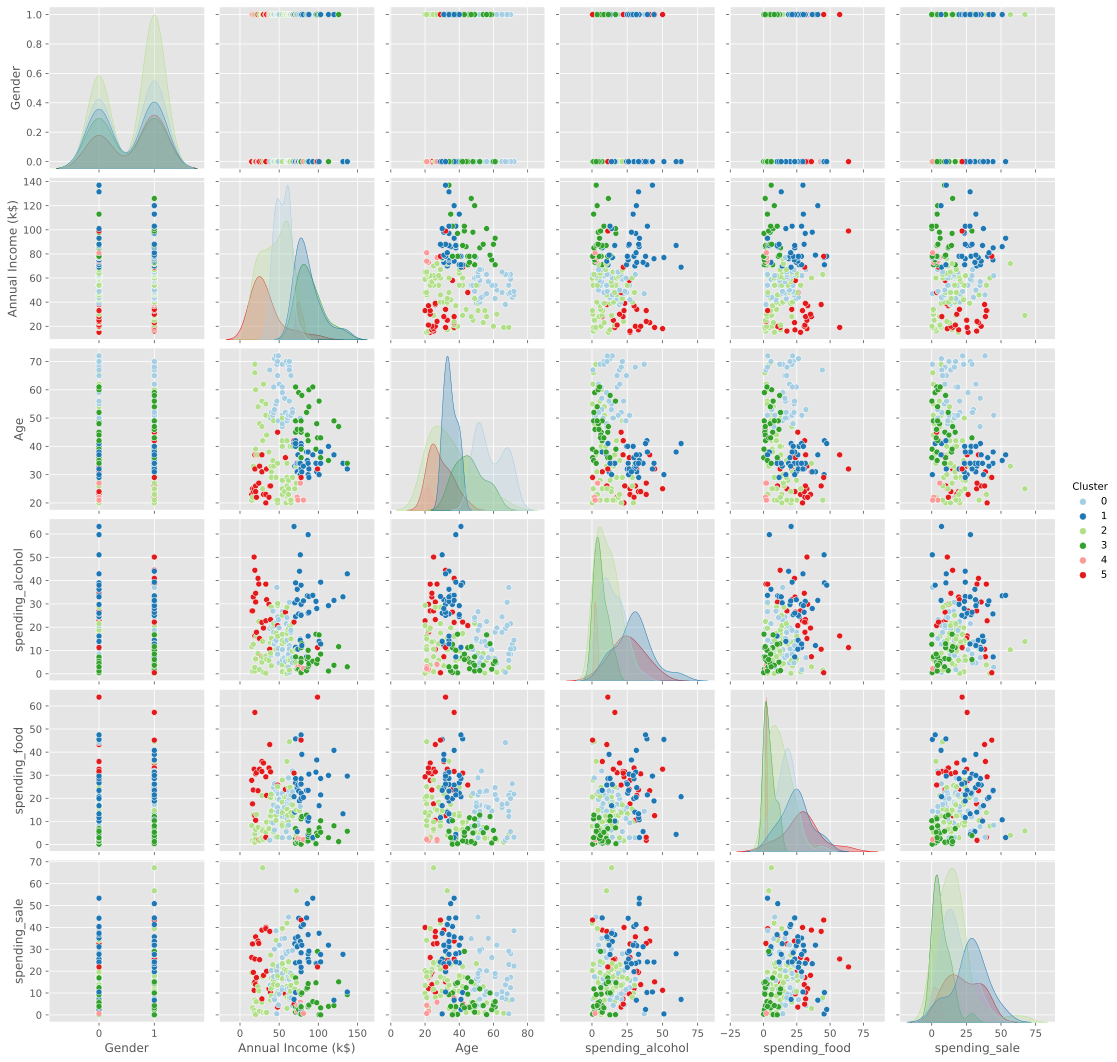

In [163]:
#then UMAP
#lets plot the clusters
#only show non outliers
dforig['Cluster']=cluster_labels_umap
show_pairplot(dforig,hue='Cluster');

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

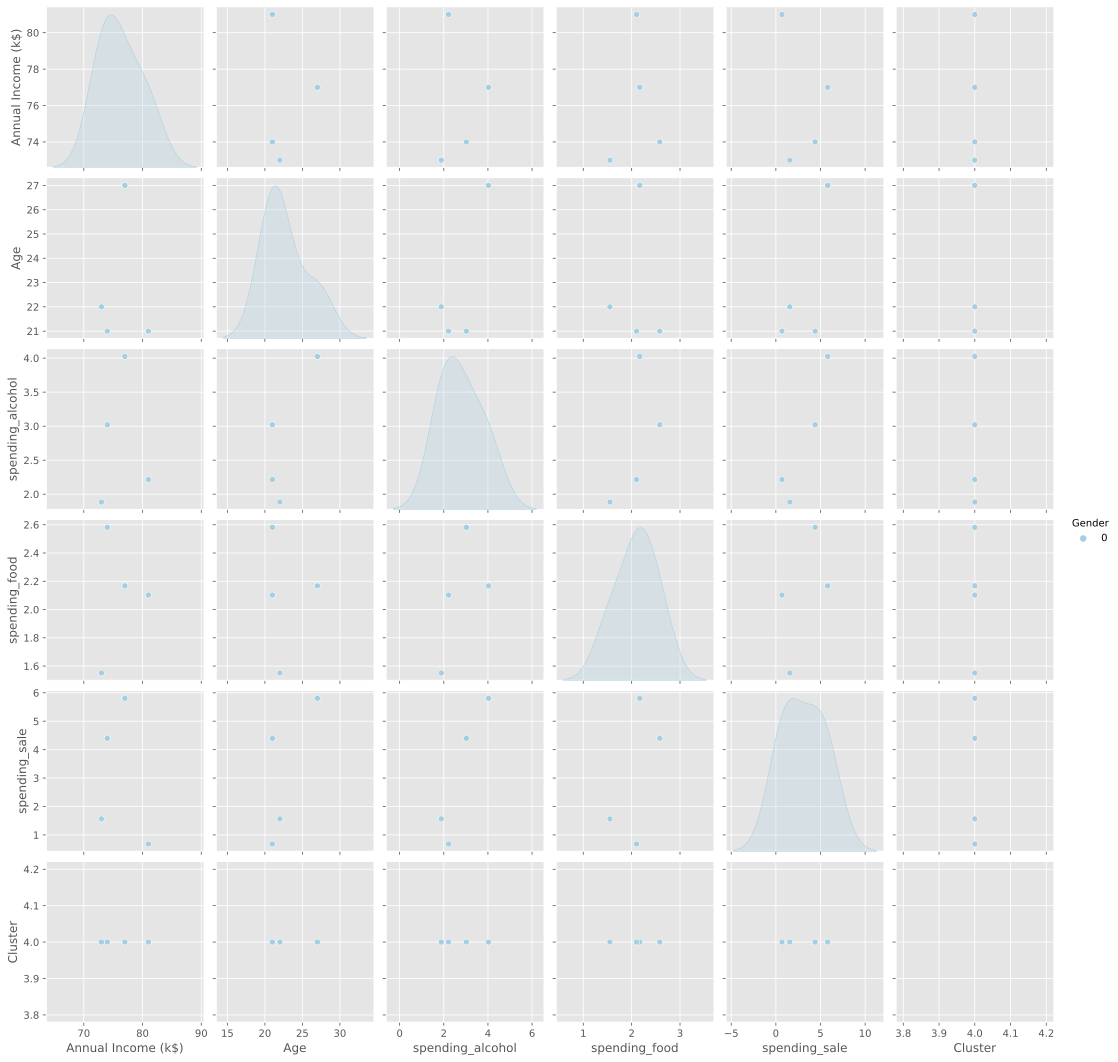

In [166]:
dfslce=dforig[dforig.Cluster==4]
show_pairplot(dfslce,hue='Gender');

## Its hard to tell what the clusters mean. Lets try groupby

In [168]:
#PCA
#lets see the means of each cluster
dforig['Cluster']=cluster_labels_pca
dforig.groupby('Cluster').mean().sort_values(by='Age')

Gender  Annual Income (k$)        Age  spending_alcohol  \
Cluster                                                              
2        0.571429           41.081633  27.285714         20.526897   
4        0.608696           73.391304  33.869565         16.147102   
0        0.521739           89.847826  35.304348         34.168185   
3        0.473684           86.684211  41.921053          6.414269   
1        0.619048           26.285714  47.523810          6.564775   
5        0.586957           54.434783  57.630435         15.090294   

         spending_food  spending_sale  
Cluster                                
2            22.105393      20.061588  
4            17.309032      40.804735  
0            29.300349      19.618422  
3             5.135406       7.213483  
1             6.536645       6.279533  
5            16.754401      16.611827

In [169]:
dforig['Cluster'].value_counts()

Cluster
2    49
5    46
3    38
4    23
0    23
1    21
Name: count, dtype: int64

In [170]:
#UMAP
#lets see the means of each cluster
dforig['Cluster']=cluster_labels_umap
dforig.groupby('Cluster').mean().sort_values(by='Age')

Gender  Annual Income (k$)        Age  spending_alcohol  \
Cluster                                                              
4        0.000000           76.250000  22.750000          2.786788   
5        0.615385           34.192308  29.192308         25.476347   
1        0.527778           86.986111  34.972222         29.765298   
2        0.622951           45.114754  35.245902         11.182147   
3        0.500000           90.200000  46.266667          6.374984   
0        0.558140           54.279070  58.674419         14.427491   

         spending_food  spending_sale  
Cluster                                
4             2.100448       3.112764  
5            29.035826      22.910904  
1            24.278299      27.789736  
2            12.531141      15.696548  
3             4.461278       7.063738  
0            16.807150      17.788614

In [ ]:
dforig['Cluster'].value_counts()

# HDBscan  

(this is not DBSCAN so no guessing min_samples and then using kneed to find eps at knee point)

This first part will run HDBscan over several cluster_sizes and min_sample_sizes, calculating several metrics for each run

The runs are then sorted by metric of choice (currently silhouette score, but you can choose any of the other metrics in hdbres)

In [ ]:
#hdbscan is not part of scikitlearn or a standard anaconda distribution, here is how to install
# !conda install -c conda-forge hdbscan -y

import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score

class hdbres():
    '''
    Bookkeeping class to hold data
    '''
    def __init__(self,min_cluster_size,min_samples,n_clusters,n_noise,labels, sil_score ):
        self.min_cluster_size=min_cluster_size
        self.min_samples=min_samples
        self.n_clusters=n_clusters
        self.n_noise=n_noise
        self.labels=labels  #all the cluster labels for my data
        self.sil_score=sil_score
    def __repr__(self):
        return str(f'self.min_cluster_size:{self.min_cluster_size},min_samples:{self.min_samples}, numb clusters:{self.n_clusters},noise points: {self.n_noise}, silhouette_score: {self.sil_score}\n')


def runHDBSCANandsilhouette(features, cluster_sizes=[3,4,5,6,7,8,9,10,11,12,13,14,15],min_samps=[2,3,4],ignore_outliers_for_sil_score=True):
    '''
    runs HDBSCAN on the features and returns results
    cluster_sizes : list of cluster sizes to try
    features: which features to run kmeans on'''
    res=[]
    for cluster_size in cluster_sizes:
        for min_samp in min_samps:             
            db = hdbscan.HDBSCAN(min_cluster_size=cluster_size, min_samples=min_samp)
            db=db.fit(features)
            
            #cluster labels for dataset
            cluster_labels = db.labels_
            
            # Number of clusters in labels, ignoring noise if present.
            n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
            n_noise = list(cluster_labels).count(-1)
                    
            #ignore outliers when calculating silhouette score
            if ignore_outliers_for_sil_score:
                sil_score=silhouette_score(features[cluster_labels!=-1], cluster_labels[cluster_labels!=-1])
            else:
                sil_score=silhouette_score(df, cluster_labels)  
      
            res.append(hdbres(cluster_size,min_samp,n_clusters,n_noise,cluster_labels,sil_score))
    return res

In [ ]:
# ??hdbscan.HDBSCAN

In [ ]:
res=runHDBSCANandsilhouette(features_pca)
res=sorted(res, key=lambda x: x.sil_score)
print(res)


In [ ]:
# this one looks good
# self.min_cluster_size:12,min_samples:2, numb clusters:6,noise points: 89, silhouette_score: 0.347318340474156
len(res)
cluster_labels=res[-3].labels.tolist()  #get third one from the end
dforig['Cluster']=cluster_labels
show_pairplot(dforig[dforig.Cluster!=-1],hue='Cluster');  #ignore outliers
# show_pairplot(dforig,hue='Cluster');

## Its hard to tell what the clusters mean. Lets try groupby

In [ ]:
#UMAP
#lets see the means of each cluster
dforig.groupby('Cluster').mean().sort_values(by='Age')

# Any noticable relationships?

In [ ]:
dcopy=dforig[dforig['Cluster']!=-1].copy()
dcopy['Cluster']=dcopy['Cluster'].astype('str')

#looks like there is a relationship between Gender and age for cluster membership, lets plot
sns.barplot(data=dcopy, y='Age',x='Gender',hue='Cluster');

In [ ]:

# sns.displot(dcopy, x="Age", bins=20, hue='Gender')
sns.displot(dcopy, x="spending_alcohol", hue='Gender',kind="kde")


## Comparison

- **K-Means** forces every point into one of `k` clusters.
- **DBSCAN** can leave points as noise and can find non-spherical clusters.

### Prompts (for students)
1. Try clustering with only the 2 classic features: `Annual Income (k$)` and `Spending Score (1-100)`. How do results change?
2. How sensitive is DBSCAN to `eps`? Find an `eps` that produces:
   - too many noise points,
   - and too few (everything in one blob).
3. Add a cluster-quality metric like silhouette score for K-Means (optional extension).
